# Binary Classification

k-Nearest Neighbour is a classifier that can learn the decision boundary between interictal and preictal segments. Spectral power bands extracted from raw EEG signal is used as input and a target label is specified alongside. We use the following convention for target label:

- 0: interictal segment
- 1: preictal segment

In [1]:
import os
import re
import h5py
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from collections import Counter
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler 
import matplotlib.pyplot as plt

In [2]:
data_dir = '/Volumes/My Passport/AI_Research/data/'
patient_names = [name for name in next(os.walk(data_dir))[1]
                 if name != '.ipynb_checkpoints' 
                 if name != 'Patient_1' 
                 if name != 'Patient_2']
patient_names

['Dog_1', 'Dog_2', 'Dog_3', 'Dog_4', 'Dog_5']

## Load data matrix and target vector

In [3]:
for i in range(len(patient_names) - 4):
    patient_name = patient_names[i]
    files_dir = data_dir + patient_name + '/' + 'Power_In_Band_Features' + '/'
    patient_files = os.listdir(files_dir)
    interictal_features = []
    preictal_features = []
    for j in tqdm(range(len(patient_files)), desc=patient_name):
        patient_file_name = patient_files[j]
        h5_path = files_dir + patient_file_name
        if not re.findall('_test_segment_', patient_file_name):
            with h5py.File(h5_path, "r") as f:
                group_key = list(f.keys())[0]
                data = np.array(f.get(group_key))
            if re.findall('_interictal_segment_', patient_file_name):
                interictal_features.append(data)
            if re.findall('_preictal_segment_', patient_file_name):
                preictal_features.append(data)    
    interictal_ys = np.zeros((len(interictal_features),))
    preictal_ys = np.ones(len(preictal_features))
    
    interictal_features = np.stack(interictal_features, axis=0)
    preictal_features = np.stack(preictal_features, axis=0)
    
    X = np.vstack((interictal_features, preictal_features))
    y = np.concatenate((interictal_ys, preictal_ys), axis=0)

Dog_1: 100%|██████████| 504/504 [00:01<00:00, 491.59it/s]


In [4]:
print('X:', X.shape)
print('y:', y.shape)

X: (504, 16, 6)
y: (504,)


## Visualisation

In [5]:
delta = X[:,:,0:1]
theta = X[:,:,1:2]
alpha = X[:,:,2:3]
beta = X[:,:,3:4]
low_gamma = X[:,:,4:5]
high_gamma = X[:,:,5:6]

What is the distribution of power values in the different bands?

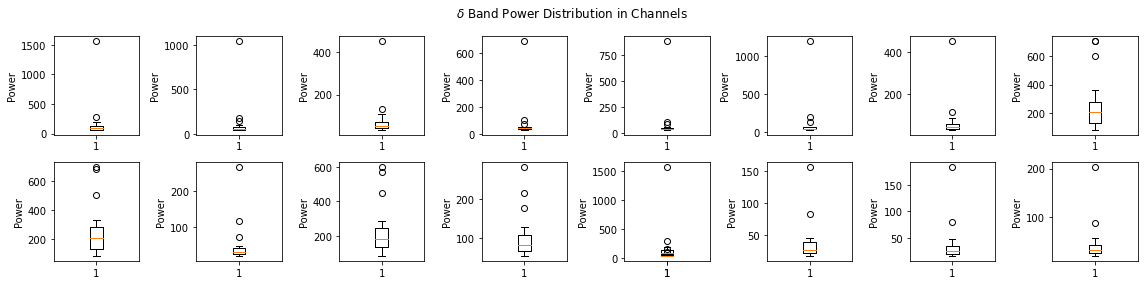

In [6]:
# delta across all channels
fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8)
axes[1,4].boxplot(delta[i])
for i in range(0,8):
    axes[0,i].boxplot(delta[i])
    axes[0,i].set_ylabel('Power')
for i in range(0, 8):
    axes[1,i].boxplot(delta[i+8])
    axes[1,i].set_ylabel('Power')
fig.suptitle(r'$\delta$ Band Power Distribution in Channels')
fig.tight_layout()

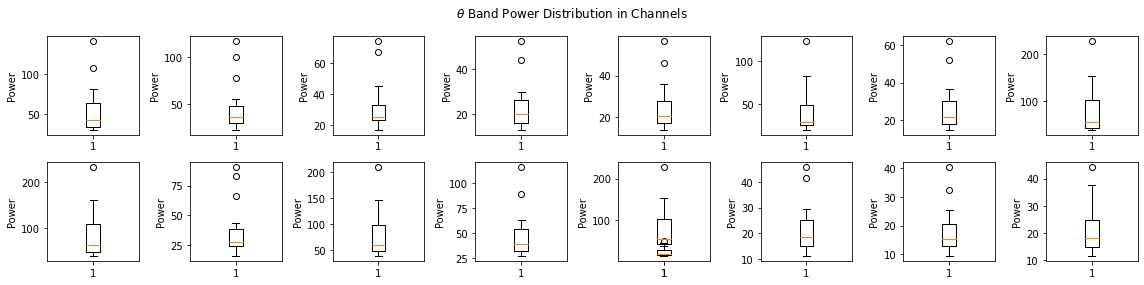

In [7]:
# theta across all channels
fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8)
axes[1,4].boxplot(theta[i])
for i in range(0,8):
    axes[0,i].boxplot(theta[i])
    axes[0,i].set_ylabel('Power')
for i in range(0, 8):
    axes[1,i].boxplot(theta[i+8])
    axes[1,i].set_ylabel('Power')
fig.suptitle(r'$\theta$ Band Power Distribution in Channels')
fig.tight_layout()

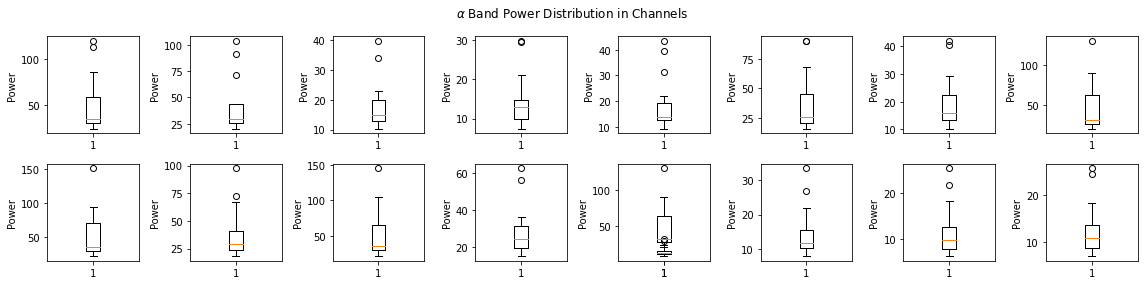

In [8]:
# alpha across all channels
fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8)
axes[1,4].boxplot(alpha[i])
for i in range(0,8):
    axes[0,i].boxplot(alpha[i])
    axes[0,i].set_ylabel('Power')
for i in range(0, 8):
    axes[1,i].boxplot(alpha[i+8])
    axes[1,i].set_ylabel('Power')
fig.suptitle(r'$\alpha$ Band Power Distribution in Channels')
fig.tight_layout()

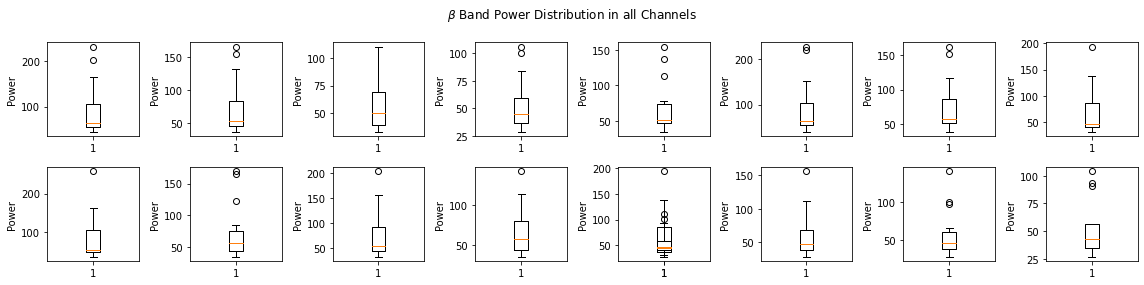

In [9]:
# beta across all channels
fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8)
axes[1,4].boxplot(beta[i])
for i in range(0,8):
    axes[0,i].boxplot(beta[i])
    axes[0,i].set_ylabel('Power')
for i in range(0, 8):
    axes[1,i].boxplot(beta[i+8])
    axes[1,i].set_ylabel('Power')
fig.suptitle(r'$\beta$ Band Power Distribution in all Channels')
fig.tight_layout()

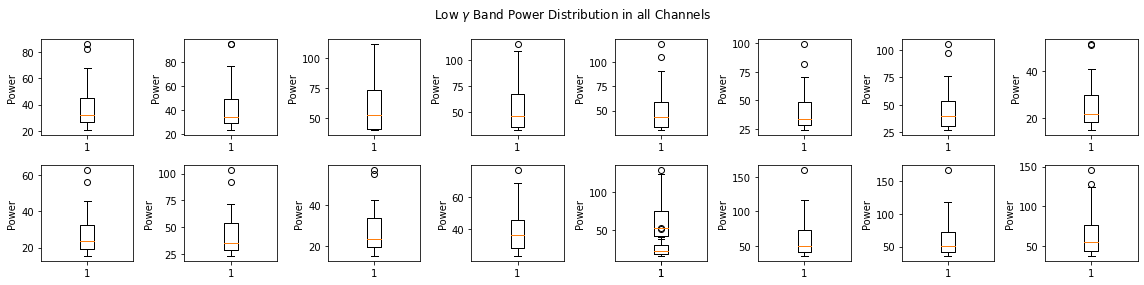

In [10]:
# low_gamma across all channels
fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8)
axes[1,4].boxplot(low_gamma[i])
for i in range(0,8):
    axes[0,i].boxplot(low_gamma[i])
    axes[0,i].set_ylabel('Power')
for i in range(0, 8):
    axes[1,i].boxplot(low_gamma[i+8])
    axes[1,i].set_ylabel('Power')
fig.suptitle(r'Low $\gamma$ Band Power Distribution in all Channels')
fig.tight_layout()

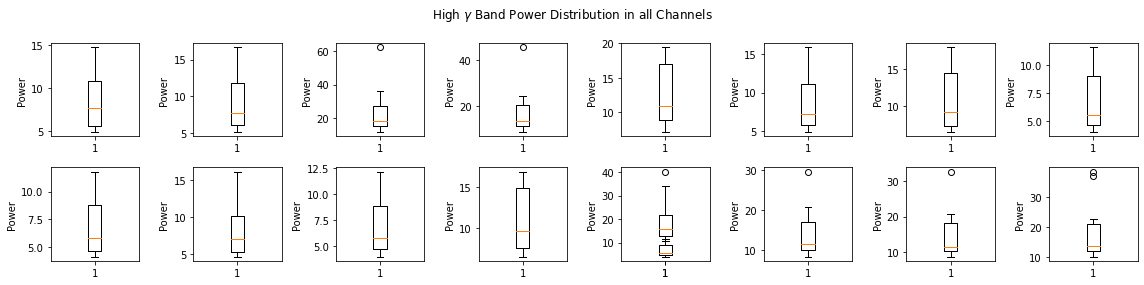

In [11]:
# high_gamma across all channels
fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8)
axes[1,4].boxplot(high_gamma[i])
for i in range(0,8):
    axes[0,i].boxplot(high_gamma[i])
    axes[0,i].set_ylabel('Power')
for i in range(0, 8):
    axes[1,i].boxplot(high_gamma[i+8])
    axes[1,i].set_ylabel('Power')
fig.suptitle(r'High $\gamma$ Band Power Distribution in all Channels')
fig.tight_layout()

How does the value of a band change over sequences?

In [66]:
n = 480
sequences = np.arange(1, n+1) # there are 480 interictal segments in the sequence
sequences.shape

(480,)

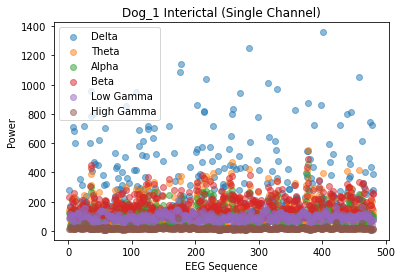

In [71]:
alph = 0.5
fig, ax = plt.subplots()
ax.scatter(sequences, delta[0:n:,0].squeeze(), label='Delta', alpha=alph)
ax.scatter(sequences, theta[0:n:,0].squeeze(), label='Theta', alpha=alph)
ax.scatter(sequences, alpha[0:n:,0].squeeze(), label='Alpha', alpha=alph)
ax.scatter(sequences, beta[0:n:,0].squeeze(), label='Beta', alpha=alph)
ax.scatter(sequences, low_gamma[0:n:,0].squeeze(), label='Low Gamma', alpha=alph)
ax.scatter(sequences, high_gamma[0:n:,0].squeeze(), label='High Gamma', alpha=alph)
ax.set_xlabel('EEG Sequence')
ax.set_ylabel('Power')
ax.set_title('Dog_1 Interictal (Single Channel)')
ax.legend()

In [90]:
n = 480
sequences = np.arange(n, n+24) # there are 24 preictal segments in the sequence

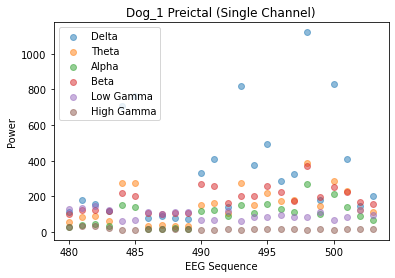

In [89]:
alph = 0.5
fig, ax = plt.subplots()
ax.scatter(sequences, delta[n::,0].squeeze(), label='Delta', alpha=alph)
ax.scatter(sequences, theta[n::,0].squeeze(), label='Theta', alpha=alph)
ax.scatter(sequences, alpha[n::,0].squeeze(), label='Alpha', alpha=alph)
ax.scatter(sequences, beta[n::,0].squeeze(), label='Beta', alpha=alph)
ax.scatter(sequences, low_gamma[n::,0].squeeze(), label='Low Gamma', alpha=alph)
ax.scatter(sequences, high_gamma[n::,0].squeeze(), label='High Gamma', alpha=alph)
ax.set_xlabel('EEG Sequence')
ax.set_ylabel('Power')
ax.set_title('Dog_1 Preictal (Single Channel)')
ax.legend(loc=2)

## Tackling class imbalance

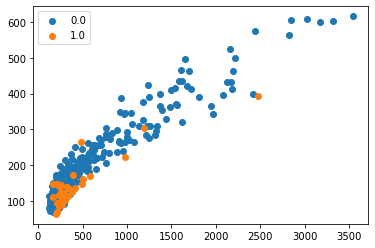

Counter({0.0: 450, 1.0: 30})


In [5]:
# visualise class scatter
counter = Counter(y)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()
print(counter)

### Undersampling

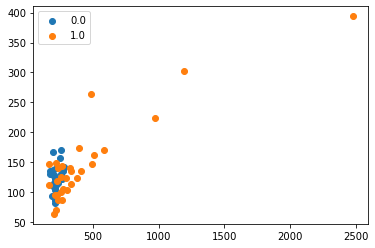

Counter({0.0: 30, 1.0: 30})


In [6]:
# define the undersampling method
undersample = NearMiss(version=1, n_neighbors=5)
# transform the dataset
X_under, y_under = undersample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_under)

# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y_under == label)[0]
    plt.scatter(X_under[row_ix, 0], X_under[row_ix, 1], label=str(label))
plt.legend()
plt.show()
print(counter)

### Oversampling

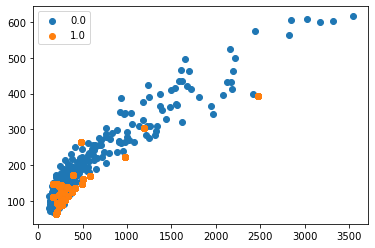

Counter({0.0: 450, 1.0: 450})


In [7]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_over)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y_over == label)[0]
    plt.scatter(X_over[row_ix, 0], X_over[row_ix, 1], label=str(label))
plt.legend()
plt.show()
# summarize class distribution
print(Counter(y_over))

## Create validation set

We create 3 validation sets, first from the imbalananced data, second from the undersampled interictal class and third from oversampled preictal class.

In [8]:
# imbalanced class
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
print(X_train.shape)
print(X_val.shape)

(321, 90)
(159, 90)


In [10]:
# undersampled class
X_train_under, X_val_under, y_train_under, y_val_under = train_test_split(X_under, y_under, test_size=0.33, 
                                                                         random_state=42)

In [11]:
print(X_train_under.shape)
print(X_val_under.shape)

(40, 90)
(20, 90)


In [12]:
# oversampled class
X_train_over, X_val_over, y_train_over, y_val_over = train_test_split(X_over, y_over, test_size=0.33,
                                                                     random_state=42)

In [13]:
print(X_train_over.shape)
print(X_val_over.shape)

(603, 90)
(297, 90)


## Model performance

In [14]:
# hyperparameter
k = 3
target_names = ['Interictal', 'Preictal']

In [15]:
# imbalanced class
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
y_preds = knn.predict(X_val)

acc = accuracy_score(y_val, y_preds)
print('Imbalanced class')
print(classification_report(y_val, y_preds, target_names=target_names))

Imbalanced class
              precision    recall  f1-score   support

  Interictal       0.93      0.98      0.96       145
    Preictal       0.57      0.29      0.38        14

    accuracy                           0.92       159
   macro avg       0.75      0.63      0.67       159
weighted avg       0.90      0.92      0.91       159



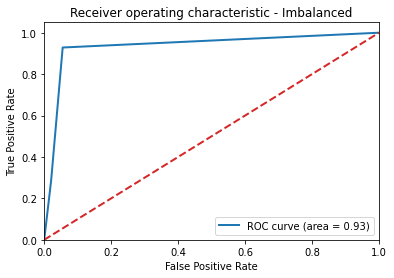

In [16]:
# ROC - imbalanced class
y_val_score = knn.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_val_score)
roc_auc = auc(fpr, tpr)

lw = 2 # line width
plt.figure()
plt.plot(fpr, tpr, color='tab:blue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='tab:red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Imbalanced')
plt.legend(loc="lower right")
plt.show()

In [17]:
# undersampled class
knn_under = KNeighborsClassifier(n_neighbors=k)
knn_under.fit(X_under, y_under)
y_preds_under = knn.predict(X_val_under)

acc_under = accuracy_score(y_val_under, y_preds_under)

print('Undersampled class')
print(classification_report(y_val_under, y_preds_under, target_names=target_names))

Undersampled class
              precision    recall  f1-score   support

  Interictal       0.58      0.78      0.67         9
    Preictal       0.75      0.55      0.63        11

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



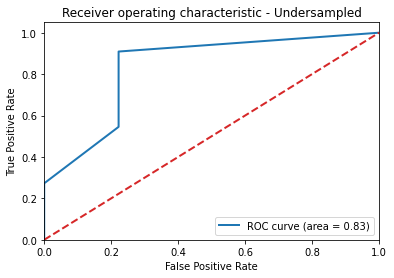

In [18]:
# ROC - undersampled class
y_val_under_score = knn.predict_proba(X_val_under)[:, 1]
fpr, tpr, _ = roc_curve(y_val_under, y_val_under_score)
roc_auc = auc(fpr, tpr)

lw = 2 # line width
plt.figure()
plt.plot(fpr, tpr, color='tab:blue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='tab:red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Undersampled')
plt.legend(loc="lower right")
plt.show()

In [19]:
# oversampled class
knn_over = KNeighborsClassifier(n_neighbors=k)
knn_over.fit(X_over, y_over)
y_preds_over = knn.predict(X_val_over)

acc_over = accuracy_score(y_val_over, y_preds_over)
print('Oversampled class')
print(classification_report(y_val_over, y_preds_over, target_names=target_names))

Oversampled class
              precision    recall  f1-score   support

  Interictal       0.68      0.99      0.81       153
    Preictal       0.99      0.51      0.68       144

    accuracy                           0.76       297
   macro avg       0.84      0.75      0.74       297
weighted avg       0.83      0.76      0.75       297



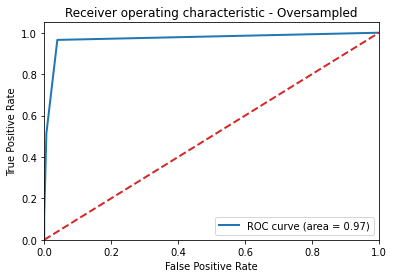

In [20]:
# ROC - oversampled class
y_val_over_score = knn.predict_proba(X_val_over)[:, 1]
fpr, tpr, _ = roc_curve(y_val_over, y_val_over_score)
roc_auc = auc(fpr, tpr)

lw = 2 # line width
plt.figure()
plt.plot(fpr, tpr, color='tab:blue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='tab:red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Oversampled')
plt.legend(loc="lower right")
plt.show()

## Cross-validation and hyperparameter tuning

Max accuracy: 0.95


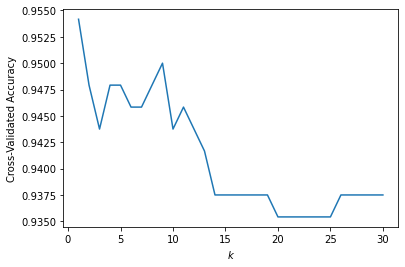

In [21]:
# 10-fold cross-validation with k=3 for k-NN
knn = KNeighborsClassifier(n_neighbors=5)

k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

# fit the grid with data
grid.fit(X, y)

grid_mean_scores = grid.cv_results_['mean_test_score']
plt.plot(k_range, grid_mean_scores)
plt.xlabel(r'$k$')
plt.ylabel('Cross-Validated Accuracy')

print('Max accuracy: {max_acc:.2f}'.format(max_acc = np.max(grid_mean_scores)))